# Assess Active Learning Effectiveness
See if an active learning optimization gets better candidates than a conventional search.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
from rdkit import Chem, DataStructs
import pandas as pd
import numpy as np
import json
params = {'legend.fontsize': 8,
         'axes.labelsize': 9,
         'axes.titlesize':'x-large',
         'xtick.labelsize': 6,
         'ytick.labelsize': 6}
plt.rcParams.update(params)

RDKit WARNING: [18:19:43] Enabling RDKit 2019.09.3 jupyter extensions


## Load Runs
Get the data from the productive-level runs

In [2]:
runs = list(Path("prod-runs").glob("*"))

In [3]:
def get_run_data(path: Path):
    """Get the data about a run
    
    Args:
        path: Path to the run
    Returns:
        (dict) Data about the run
    """
    
    # Get the basic information
    output = dict(path=path, study=path.name.split("_")[-1])
    with open(path.joinpath('run_params.json')) as fp:
        run_params = json.load(fp)
    output['num_nodes'] = run_params['nnodes']
    for k in ['random', 'retrain_frequency', 'nodes_per_task']:
        output[k] = run_params[k]
    
    # Get the start-time
    with open(path.joinpath('runtime.log')) as fp:
        line = fp.readline().strip()
        start_time = datetime.strptime(line.split(" - ")[0].strip(), "%Y-%m-%d %H:%M:%S,%f")
    
    # Get the molecules that were scanned
    with open(path.joinpath('moldata-records.json')) as fp:
        records = [
            json.loads(x)  # First record is the save time
            for x in fp
        ]
        output['time'] = [(datetime.fromtimestamp(x[0]) - start_time).total_seconds() for x in records]
        mol_data = [json.loads(x[1]) for x in records]
    output['molecules'] = [x['identifier']['smiles'] for x in mol_data]
    output['ip'] = [x['oxidation_potential'].get('smb-vacuum') for x in mol_data]
    
    # Determine when models were retrained
    with open(path.joinpath('runtime.log')) as fp:
        output['task_update_times'] = [
            (datetime.strptime(x.split(" - ")[0].strip(), '%Y-%m-%d %H:%M:%S,%f') - start_time).total_seconds()
            for x in fp if 'Updated task list' in x
        ]
            
    return output

In [4]:
results = pd.DataFrame([get_run_data(x) for x in runs])

## Plot the IPs over time.
Study which get "better" molecules

In [5]:
subset = results.query('num_nodes==256 and retrain_frequency != 16')

no-retrain: 13.185886652140686 9.793224396301534
random: 10.097322089613051 8.214968985584612
retrain-8: 14.61816608057224 9.734766458670741


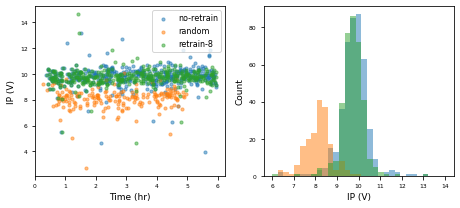

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.))

for gid, group in subset.groupby('study'):
    group = group.iloc[0]
    axs[0].scatter(np.divide(group['time'], 3600), group['ip'], label=gid, s=10, alpha=0.5)
    
    axs[1].hist(group['ip'], bins=np.linspace(6, 14, 32), alpha=0.5)
    print(f'{gid}: {np.max(group["ip"])} {np.median(group["ip"])}')
    
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('IP (V)')

axs[1].set_xlabel('IP (V)')
axs[1].set_ylabel('Count')
axs[0].set_xlim(0, max(axs[0].get_xlim()))
axs[0].legend()

fig.tight_layout()

no-retrain: 148/431 0.07888631090487239 
random: 1/185 0.0 
retrain-8: 94/359 0.04456824512534819 


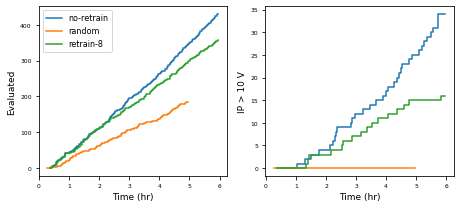

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.))

for gid, group in subset.groupby('study'):
    group = group.iloc[0]
    axs[0].step(np.divide(group['time'], 3600), range(len(group['ip'])), label=gid)
    
    axs[1].step(np.divide(group['time'], 3600), np.cumsum(np.greater(group['ip'], 10.5)), label=gid)
    print(f'{gid}: {np.greater(group["ip"], 10).sum()}/{len(group["ip"])} {np.greater(group["ip"], 10.5).mean()} ')
    
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Evaluated')

axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('IP > 10 V')
axs[0].set_xlim(0, max(axs[0].get_xlim()))
axs[0].legend()

fig.tight_layout()

no-retrain: 148 0.3433874709976798
random: 1 0.005405405405405406
retrain-8: 94 0.2618384401114206


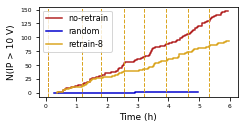

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 1.9))

thresh = 10
colors = ['firebrick', 'mediumblue', 'goldenrod']

# Plot the performances
for (gid, group), c in zip(subset.groupby('study'), colors):
    group = group.iloc[0]    
    ax.step(np.divide(group['time'], 3600), np.cumsum(np.greater(group['ip'], thresh)), label=gid, color=c)
    print(f'{gid}: {np.greater(group["ip"], thresh).sum()} {np.greater(group["ip"], thresh).mean()}')
    
# Pot the retraining events
ax.set_ylim(ax.get_ylim())
for (gid, group), c in zip(subset.groupby('study'), colors):
    group = group.iloc[0]
    for t in group['task_update_times']:
        ax.plot([t/3600]*2, ax.get_ylim(), '--', color=c, lw=1.)
            
#ax.text(0.05, 0.99, '(b)', transform=axs[1].transAxes, va='top')
ax.set_xlabel('Time (h)')
ax.set_ylabel(f'N(IP > {thresh} V)')

#for ax in axs:
#    ax.set_xlim(0, max(axs[0].get_xlim()))
ax.legend(loc='upper left')

fig.tight_layout()
fig.savefig('figures/optimization-performance.pdf')

Check how many molecules are being run more than once

In [9]:
evaled_mols = subset.query('retrain_frequency==8').iloc[0]['molecules']

In [10]:
print(f'Evaluated {len(set(evaled_mols))} unique molecules out of a total of {len(evaled_mols)}')

Evaluated 357 unique molecules out of a total of 359


## Assess Similarity
We use the uncertainty as a metric for ranking candidates. Wierd stuff could happen if we get high certainity in a certain region of molecules

In [11]:
def compute_similarities(molecules) -> np.ndarray:
    """Compute the similarity between each molecule"""
    # Parse all of the molecules
    mols = [Chem.MolFromSmiles(m) for m in molecules[-200:]]
    
    # Compute fingerprints
    fps = [Chem.RDKFingerprint(x) for x in mols]
    
    # Compute pairwise similarities
    output = []
    for i, m in enumerate(fps):
        output.extend([DataStructs.FingerprintSimilarity(m, n) for n in fps[(i+1):]])
    return output

In [12]:
results = {}
for _, run in subset.iterrows():
    results[run['study']] = compute_similarities(run['molecules'])
    print(run['study'], np.mean(results[run['study']]))

retrain-8 0.08242879171749613
random 0.09419195996437965
no-retrain 0.0757136324982618


Maybe more similar?